In [14]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    accuracy_score, f1_score, log_loss, plot_roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, \
    GradientBoostingClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

In [15]:
df = pd.read_csv('data/bank_data.csv')

df.head(5)

age        job   marital            education  default housing loan  \
0   39     admin.   married    university.degree  unknown      no   no   
1   31   services  divorced          high.school       no     yes   no   
2   34   services  divorced          high.school       no     yes   no   
3   23     admin.    single  professional.course       no     yes   no   
4   63  housemaid   married             basic.4y       no      no   no   

    contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0  cellular   jul         thu  ...         3    999         0  nonexistent   
1  cellular   jul         mon  ...         1    999         0  nonexistent   
2  cellular   may         fri  ...         1    999         0  nonexistent   
3  cellular   jul         wed  ...         2    999         0  nonexistent   
4  cellular   aug         tue  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0          1.4          93.918          -42.7      4.968       5228.1 -1  
1          1.4          93.918          -42.7      4.960       5228.1 -1  
2         -1.8          92.893          -46.2      1.250       5099.1 -1  
3          1.4          93.918          -42.7      4.963       5228.1 -1  
4         -2.9          92.201          -31.4      0.838       5076.2  1  

[5 rows x 21 columns]

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [17]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

In [18]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''
    
    mask = np.random.choice([True, False], size=features.shape[0], 
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps
    
    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)
    
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()
    
    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

In [19]:
def plot_calibration_curve(y_test, preds, n_bins):
    bin_middle_points = []
    bin_real_ratios = []
    for i in range(n_bins):
        l = (1.0 / n_bins) * i
        r = (1.0 / n_bins) * (i + 1)
        bin_middle_points.append((r + l) / 2) 
        mask = (preds >= l) & (preds < r)
        y_test_masked = y_test[(preds >= l) & (preds < r)]
        y_test_masked_1 = y_test_masked[y_test_masked==1]
#         print(l, r, y_test_masked.shape, y_test_masked_1.shape)
        bin_real_ratios.append(y_test_masked_1.shape[0] / y_test_masked.shape[0])
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()


In [20]:
class BoostingCustom:
    
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=20,
        learning_rate: float=0.5,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=5
    ):
        
        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping
        
        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None
        
        # Список для хранения весов при моделях
        self.gammas = []
        
        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]
        
        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)
        
        
    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """
        if n_model == 0:
            z = self.initial_model_pred * np.ones(X.shape[0])
        elif n_model > 0:
            z = self._predict_float(X, n_iter=n_model)
        
        antigrad = - self.loss_derivative(y, z)
#         print('y: ', y)
#         print('z: ', z)
#         print('loss: ', self.loss_fn(y, z))
#         print('antigrad: ', antigrad)
        self.models[n_model] = self.models[n_model].fit(X, antigrad)

        
    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. 
        Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, 
        а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        return self.sigmoid(np.sign(y.mean()))
    
    
    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss
        
        return optimal_gamma
        
        
    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
        self.initial_model_pred = self._fit_initial_model(X, y)
        
        X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=self.subsample, random_state=self.random_seed)
        
        old_predictions = self.initial_model_pred * np.ones(X_train.shape[0])
        loss = np.inf
        
        for step in range(self.n_estimators): 
#             print('loss_fn: ', self.loss_fn(y_train, old_predictions))
            self._fit_new_model(X_train, y_train, n_model=step)
            new_predictions = self.models[step].predict(X_train)
            optimal_gamma = self._find_optimal_gamma(y_train, old_predictions,
                            new_predictions, boundaries=(0.01, 1))
            self.gammas.append(optimal_gamma)
            old_predictions += self.learning_rate * optimal_gamma * new_predictions
                
            # early stopping
            if step % self.n_iter_early_stopping == 0:
                z_val = self._predict_float(X_val, n_iter=len(self.gammas))
                step_loss = self.loss_fn(y_val, z_val)
                if step_loss >= loss: 
                    break
                loss = step_loss    

                
    def _predict_float(self, X: np.ndarray, n_iter):
        prediction = self.initial_model_pred * np.ones(X.shape[0])
        for step in range(n_iter):
            prediction += self.learning_rate * self.gammas[step] * \
                self.models[step].predict(X)
        return self.sigmoid(prediction)
            
            
    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        predictions = self._predict_float(X, n_iter=len(self.gammas))
        predictions[predictions>0.5] = 1
        predictions[predictions<=0.5] = -1
        return predictions
        
    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        predictions = self._predict_float(X, n_iter=len(self.gammas))
        predictions_plus = predictions
        predictions_minus = 1 - predictions
        
        return np.c_[predictions_minus, predictions_plus]
    
        
    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса. 
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

In [21]:
# %%time

# boosting = BoostingCustom()
# boosting.fit(X_train_synthetic, y_train_synthetic)
# # Без разницы, выдает эта строка классы или вероятности
# preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
# print(accuracy_score((y_test_synthetic == 1), np.round(preds)))
# assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

In [22]:
# %%time

# boosting = BoostingCustom()
# boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# # Без разницы, выдает эта строка классы или вероятности
# preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
# print(accuracy_score((df_test.y.values == 1), np.round(preds)))
# assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

In [23]:
x_train_synthetic = X_train_synthetic
x_test_synthetic = X_test_synthetic
y_train_synthetic

array([-1.,  1., -1., ...,  1.,  1., -1.])

f1_score:  0.9071688464942472


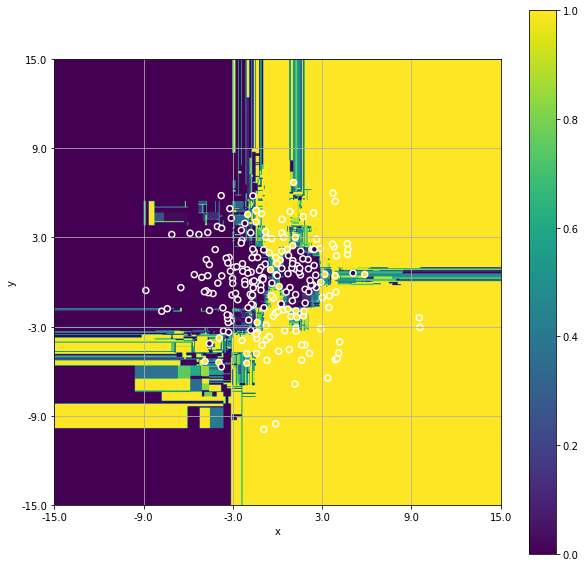

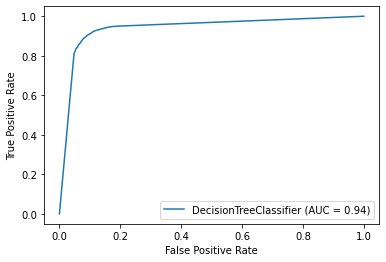

In [24]:
decision_tree = DecisionTreeClassifier(max_depth=16)
decision_tree.fit(x_train_synthetic, y_train_synthetic)
print('f1_score: ', f1_score(y_test_synthetic, \
                             decision_tree.predict(x_test_synthetic)))
plot_predicts(decision_tree, x_test_synthetic, y_test_synthetic)
plot_roc_curve(decision_tree, x_test_synthetic, y_test_synthetic)

f1_score:  0.9091179976162098


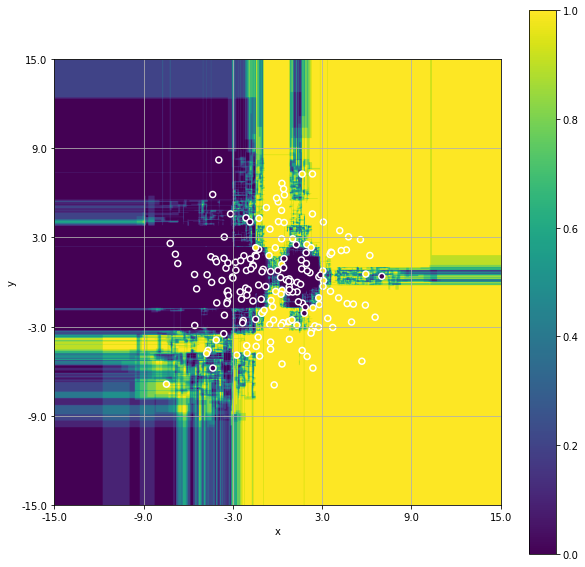

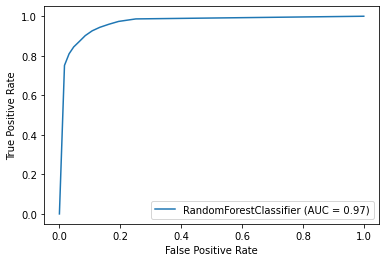

In [25]:
rand_forest = RandomForestClassifier(n_estimators=10)
rand_forest.fit(x_train_synthetic, y_train_synthetic)
print('f1_score: ', f1_score(y_test_synthetic, \
                             rand_forest.predict(x_test_synthetic)))
plot_predicts(rand_forest, x_test_synthetic, y_test_synthetic)
plot_roc_curve(rand_forest, x_test_synthetic, y_test_synthetic)

f1_score:  0.6913800803930327


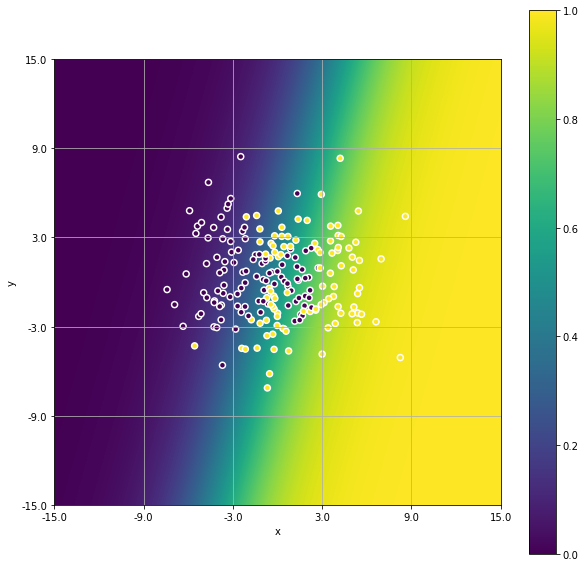

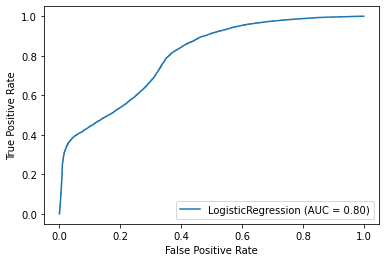

In [26]:
logit_regr = LogisticRegression()
logit_regr.fit(x_train_synthetic, y_train_synthetic)
print('f1_score: ', f1_score(y_test_synthetic, \
                             logit_regr.predict(x_test_synthetic)))
plot_predicts(logit_regr, x_test_synthetic, y_test_synthetic)
plot_roc_curve(logit_regr, x_test_synthetic, y_test_synthetic)

f1_score:  0.9013042826445457


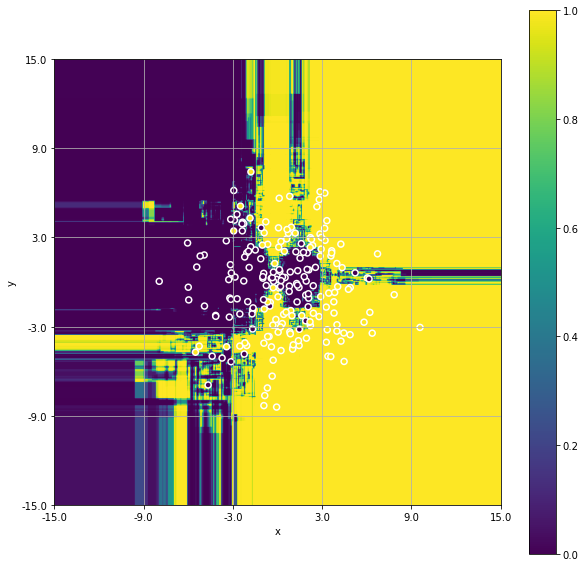

0.9705350349911067

In [27]:
custom_boosting = BoostingCustom(learning_rate=0.8, n_estimators = 20)
custom_boosting.fit(x_train_synthetic, y_train_synthetic)
custom_boosting.predict_proba(x_test_synthetic)[:15]
print('f1_score: ', f1_score(y_test_synthetic, \
                             custom_boosting.predict(x_test_synthetic)))
plot_predicts(custom_boosting, x_test_synthetic, y_test_synthetic)
roc_auc_score(y_test_synthetic, custom_boosting.predict_proba(x_test_synthetic)[:, 1])

f1_score:  0.9229713164991419


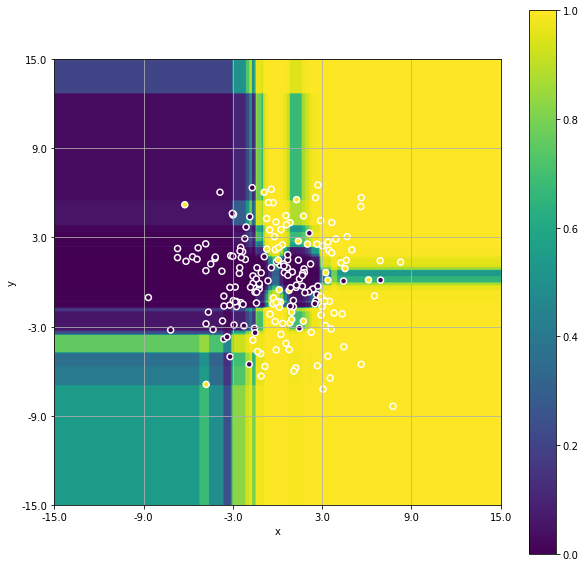

CPU times: user 2.37 s, sys: 32.2 ms, total: 2.4 s
Wall time: 2.4 s


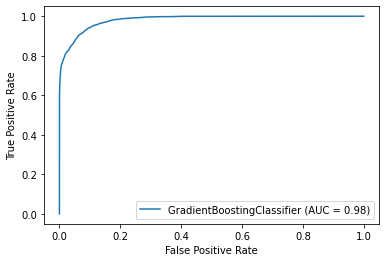

In [28]:
%%time

grad_boosting = GradientBoostingClassifier(learning_rate=0.8, n_estimators=20)
grad_boosting.fit(x_train_synthetic, y_train_synthetic)
print('f1_score: ', f1_score(y_test_synthetic, \
                             grad_boosting.predict(x_test_synthetic)))
plot_predicts(grad_boosting, x_test_synthetic, y_test_synthetic)
plot_roc_curve(grad_boosting, x_test_synthetic, y_test_synthetic)

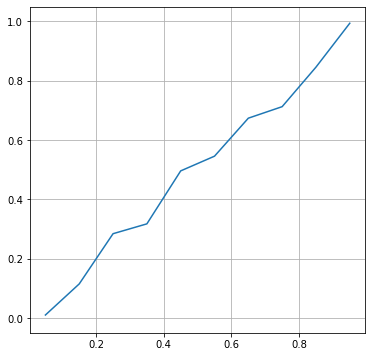

In [29]:
plot_calibration_curve(y_test_synthetic, grad_boosting.predict_proba(x_test_synthetic)[:,1], n_bins=10)

In [30]:
f1_scorer = make_scorer(f1_score)

In [31]:
# custom_boosting_searcher = GridSearchCV(\
#     estimator=GradientBoostingClassifier(learning_rate=0.7), \
#            param_grid={'n_estimators': range(10, 101, 90), 
#                        'min_samples_leaf': range(1, 6, 2), 
#                        'max_depth': range(5, 11, 2)},
#                                         scoring=f1_scorer, cv=3, verbose=5)
# custom_boosting_searcher.fit(x_train_synthetic, y_train_synthetic)

In [32]:
custom_boosting_searcher.best_params_
custom_boosting_searcher.best_score_

NameError: name 'custom_boosting_searcher' is not defined

In [ ]:
x_bank = df.drop(columns=['y'], inplace=False)
y_bank = df['y']
x_train_bank, x_test_bank, y_train_bank, y_test_bank = train_test_split(x_bank, y_bank, test_size=0.3, random_state=228)

categorical_bank = ['job', 'marital', 'education', 'default','housing','loan','contact',\
               'month','day_of_week','poutcome']
numerical_bank = ['age', 'campaign', 'pdays', 'previous','emp.var.rate','cons.price.idx',\
               'cons.conf.idx','euribor3m','nr.employed']
col_trans_bank = ColumnTransformer([('ohe', OneHotEncoder(), categorical_bank), 
                               ('scaler', StandardScaler(), numerical_bank)])

In [ ]:
grad_boosting_bank = GradientBoostingClassifier(learning_rate=0.3, n_estimators=100)
pipeline_grad_boosting_bank = Pipeline(steps=[('transformer', col_trans_bank), 
                                              ('estimator', grad_boosting_bank)])
pipeline_grad_boosting_bank.fit(x_train_bank, y_train_bank)

print('f1_score: ', f1_score(y_test_bank, \
                             pipeline_grad_boosting_bank.predict(x_test_bank)))
plot_roc_curve(pipeline_grad_boosting_bank, x_test_bank, y_test_bank)

In [ ]:
random_forest_bank = RandomForestClassifier(
                                      n_estimators=100,
                                       max_samples=0.8, 
                                       max_features=0.8)
pipeline_random_forest_bank = Pipeline(steps=[('transformer', col_trans_bank), 
                                              ('estimator', random_forest_bank)])
pipeline_random_forest_bank.fit(x_train_bank, y_train_bank)

print('f1_score: ', f1_score(y_test_bank, \
                             pipeline_random_forest_bank.predict(x_test_bank)))
plot_roc_curve(pipeline_random_forest_bank, x_test_bank, y_test_bank)

In [ ]:
bagging_bank = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1),
                                      n_estimators=100,
                                       max_samples=0.8, 
                                       max_features=0.8)
pipeline_bagging_bank = Pipeline(steps=[('transformer', col_trans_bank), 
                                              ('estimator', bagging_bank)])
pipeline_bagging_bank.fit(x_train_bank, y_train_bank)

print('f1_score: ', f1_score(y_test_bank, \
                             pipeline_bagging_bank.predict(x_test_bank)))
plot_roc_curve(pipeline_bagging_bank, x_test_bank, y_test_bank)

In [ ]:
bagging_boosting_bank = BaggingClassifier(base_estimator=grad_boosting_bank,
                                      n_estimators=10,
                                       max_samples=0.8, 
                                       max_features=0.8)
pipeline_bagging_boosting_bank = Pipeline(steps=[('transformer', col_trans_bank), 
                                              ('estimator', bagging_boosting_bank)])
pipeline_bagging_boosting_bank.fit(x_train_bank, y_train_bank)

print('f1_score: ', f1_score(y_test_bank, \
                             pipeline_bagging_boosting_bank.predict(x_test_bank)))
plot_roc_curve(pipeline_bagging_boosting_bank, x_test_bank, y_test_bank)

In [ ]:
%%time

# F1=0.71542 ; AUC-ROC=0.80
# CPU times: user 2.11 s, sys: 28 ms, total: 2.14 s
# Wall time: 2.15 s

importances = grad_boosting_bank.feature_importances_
percentile = np.percentile(importances, 15)
mask = importances>percentile
mask
x_train_bank_purned = \
    pipeline_grad_boosting_bank.named_steps.transformer.transform(x_train_bank)[:, mask]

x_test_bank_purned = \
    pipeline_grad_boosting_bank.named_steps.transformer.transform(x_test_bank)[:, mask]

grad_boosting_bank_purned = GradientBoostingClassifier(learning_rate=0.3, n_estimators=100)
grad_boosting_bank_purned.fit(x_train_bank_purned, y_train_bank)

# grad_boosting_bank = GradientBoostingClassifier(learning_rate=0.3, n_estimators=100)
# pipeline_grad_boosting_bank = Pipeline(steps=[('transformer', col_trans_bank), 
#                                               ('estimator', grad_boosting_bank)])
# pipeline_grad_boosting_bank.fit(x_train_bank, y_train_bank)

print('f1_score: ', f1_score(y_test_bank, \
                             grad_boosting_bank_purned.predict(x_test_bank_purned)))
plot_roc_curve(grad_boosting_bank_purned, x_test_bank_purned, y_test_bank)